# EWT & EFD TRF (with Matlab result)

## Read the data

In [1]:
import math
import pandas as pd
import pywt
import numpy as np
from matplotlib.pyplot import figure
from scipy import fftpack
from scipy import signal
import matplotlib.pyplot as plt
from mat4py import loadmat
import os
import scipy.io as sio
from sklearn.preprocessing import StandardScaler
from itertools import combinations, chain

For each subject, combine the three files, 49 guestures in total.

In [2]:
def import_db2_acc(folder_path, subject):
    """Function for extracting acceleronmeter data from raw NinaiPro files for DB2.
    Args:
        folder_path (string): Path to folder containing raw mat files
        subject (int): 1-40 which subject's data to import
    Returns:
        array: Raw accceleronmeter from each electrode
    """
    cur_path = os.path.normpath(folder_path + '/S' + str(subject) + '_E1_A1.mat')
    data = sio.loadmat(cur_path)
    acc = np.squeeze(np.array(data['emg']))

    cur_path = os.path.normpath(folder_path + '/S' + str(subject) + '_E2_A1.mat')
    data = sio.loadmat(cur_path)
    acc = np.vstack((acc, np.array(data['emg'])))

    cur_path = os.path.normpath(folder_path + '/S' + str(subject) + '_E3_A1.mat')
    data = sio.loadmat(cur_path)
    acc = np.vstack((acc, np.array(data['emg'])))

    return acc

In [3]:
df40 = pd.DataFrame(import_db2_acc(r'C:\Ninapro', 40))

In [4]:
#SENITY CHECK
len(df40)/(49*6)/2000
# EACH GUESTURE APPROXMATELY 5+3=8 SECONDS

8.757066326530612

## Separate the guestures (49*6=294 pieces)

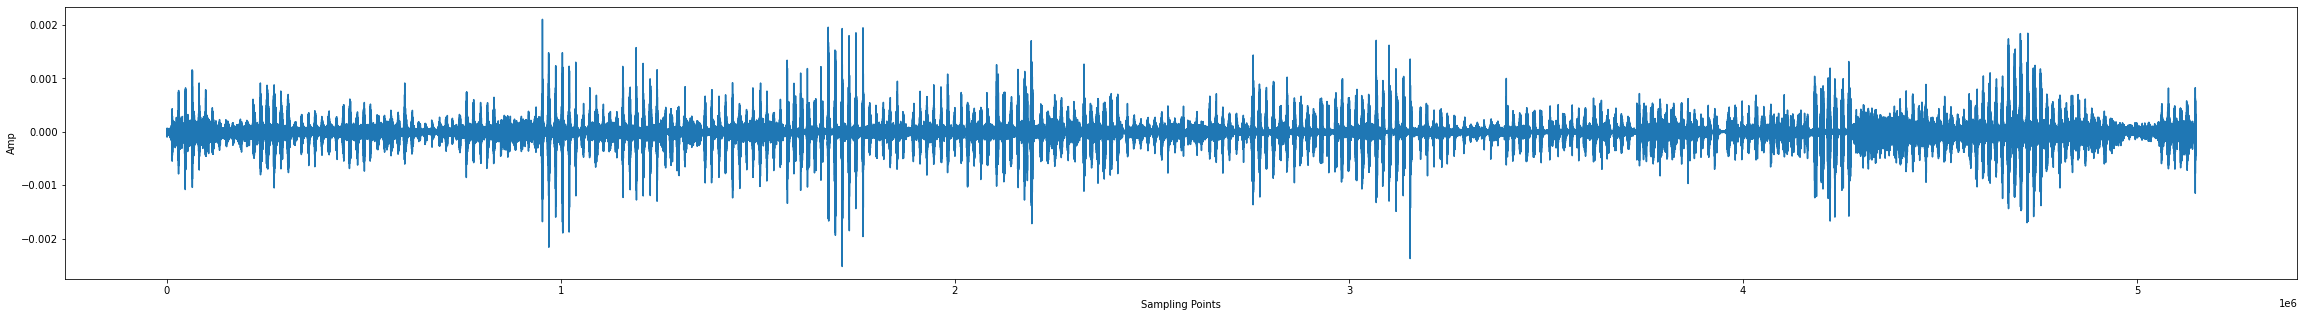

In [5]:
#%matplotlib notebook
figure(figsize=(40, 5))

plt.plot(df40[0])
plt.xlabel('Sampling Points')
plt.ylabel('Amp')

plt.show()

Cut each movement into pieces, total 294 pieces, and 588 start and ending points.

In [3]:
#https://github.com/Lif3line/nina_helper_package_mk2/blob/master/nina_helper/nina_helper.py
def import_db2_unrefined(folder_path, subject, rest_length_cap=999):
    """Get the original repetition and stimulus information DB2 (repetition still aligned as rest-move-rest).
    Args:
        folder_path (string): Path to folder containing raw mat files
        subject (int): 1-27 which subject's data to import
        rest_length_cap (int, optional): The number of seconds of rest data to keep before/after a movement
    Returns:
        Dictionary: Unrefined repetition and movement labels, indices of where repetitions are
            demarked and the number of repetitions with capped off rest data
    """
    fs = 2000

    cur_path = os.path.normpath(folder_path + '/S' + str(subject) + '_E1_A1.mat')
    data = sio.loadmat(cur_path)
    rep = np.squeeze(np.array(data['repetition']))
    move = np.squeeze(np.array(data['stimulus']))

    cur_path = os.path.normpath(folder_path + '/S' + str(subject) + '_E2_A1.mat')
    data = sio.loadmat(cur_path)
    rep = np.append(rep, np.squeeze(np.array(data['repetition'])))
    move_tmp = np.squeeze(np.array(data['stimulus']))
    move = np.append(move, move_tmp)  # Note no fix needed for this exercise

    cur_path = os.path.normpath(folder_path + '/S' + str(subject) + '_E3_A1.mat')
    data = sio.loadmat(cur_path)
    data['repetition'][-1] = 0  # Fix for diffing
    rep = np.append(rep, np.squeeze(np.array(data['repetition'])))

    # Movements number in non-logical pattern [0  1  2  4  6  8  9 16 32 40]
    data['stimulus'][-1] = 0  # Fix for diffing
    data['stimulus'][np.where(data['stimulus'] == 1)] = 41
    data['stimulus'][np.where(data['stimulus'] == 2)] = 42
    data['stimulus'][np.where(data['stimulus'] == 4)] = 43
    data['stimulus'][np.where(data['stimulus'] == 6)] = 44
    data['stimulus'][np.where(data['stimulus'] == 8)] = 45
    data['stimulus'][np.where(data['stimulus'] == 9)] = 46
    data['stimulus'][np.where(data['stimulus'] == 16)] = 47
    data['stimulus'][np.where(data['stimulus'] == 32)] = 48
    data['stimulus'][np.where(data['stimulus'] == 40)] = 49
    move_tmp = np.squeeze(np.array(data['stimulus']))
    move = np.append(move, move_tmp)

    move = move.astype('int8')  # To minimise overhead

    # Label repetitions using new block style: rest-move-rest regions
    move_regions = np.where(np.diff(move))[0]
    rep_regions = np.zeros((move_regions.shape[0],), dtype=int)
    nb_reps = int(round(move_regions.shape[0] / 2))
    last_end_idx = int(round(move_regions[0] / 2))
    nb_unique_reps = np.unique(rep).shape[0] - 1  # To account for 0 regions
    nb_capped = 0
    cur_rep = 1

    rep = np.zeros([rep.shape[0], ], dtype=np.int8)  # Reset rep array
    for i in range(nb_reps - 1):
        rep_regions[2 * i] = last_end_idx
        midpoint_idx = int(round((move_regions[2 * (i + 1) - 1] +
                                  move_regions[2 * (i + 1)]) / 2)) + 1

        trailing_rest_samps = midpoint_idx - move_regions[2 * (i + 1) - 1]
        if trailing_rest_samps <= rest_length_cap * fs:
            rep[last_end_idx:midpoint_idx] = cur_rep
            last_end_idx = midpoint_idx
            rep_regions[2 * i + 1] = midpoint_idx - 1
        else:
            rep_end_idx = (move_regions[2 * (i + 1) - 1] +
                           int(round(rest_length_cap * fs)))
            rep[last_end_idx:rep_end_idx] = cur_rep
            last_end_idx = ((move_regions[2 * (i + 1)] -
                             int(round(rest_length_cap * fs))))
            rep_regions[2 * i + 1] = rep_end_idx - 1
            nb_capped += 2

        cur_rep += 1
        if cur_rep > nb_unique_reps:
            cur_rep = 1

    end_idx = int(round((rep.shape[0] + move_regions[-1]) / 2))
    rep[last_end_idx:end_idx] = cur_rep
    rep_regions[-2] = last_end_idx
    rep_regions[-1] = end_idx - 1

    return {'rep': rep,
            'move': move,
            'rep_regions': rep_regions,
            'nb_capped': nb_capped
            }

In [7]:
len(import_db2_unrefined(r'C:\Ninapro', 40, rest_length_cap=999)['rep_regions'])

588

In [8]:
S40=import_db2_unrefined(r'C:\Ninapro', 40, rest_length_cap=999)['rep_regions']

In [9]:
len(S40)

588

In [10]:
df40.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.606062e-05,-0.000032,-4.751914e-06,-1.209524e-06,-0.000006,-0.000005,0.000004,3.023845e-07,-2.884154e-06,-0.000011,-1.192623e-06,-4.690900e-08
1,3.133519e-05,-0.000039,-5.255463e-06,3.011850e-07,-0.000005,-0.000005,0.000003,5.505653e-06,-2.287788e-06,-0.000012,4.860036e-07,3.310143e-06
2,2.059313e-05,-0.000040,-4.751914e-06,3.012514e-07,-0.000003,-0.000004,0.000004,6.344842e-06,1.681663e-08,-0.000012,2.668176e-06,4.653005e-06
3,4.515143e-07,-0.000024,-3.073422e-06,3.013177e-07,-0.000003,-0.000004,0.000007,3.994895e-06,-2.055694e-07,-0.000011,4.682500e-06,4.653073e-06
4,-4.415823e-06,0.000014,-7.235331e-07,-7.057101e-07,-0.000004,-0.000004,0.000013,6.344728e-06,-1.288087e-06,-0.000014,4.682633e-06,5.324537e-06


## Example for subject 40 chanel 1 Random guesture

In [11]:
# START POINTS OF FIRST GUESTURE IN S1 CH1
S40_C1_Gn=df40[0][1844727:1861882]
#scales = np.arange(1, 60)

In [12]:
type(S40_C1_Gn)

pandas.core.series.Series

In [13]:
S40_C1_Gn.to_csv(r'C:\Ninapro\exa.csv')

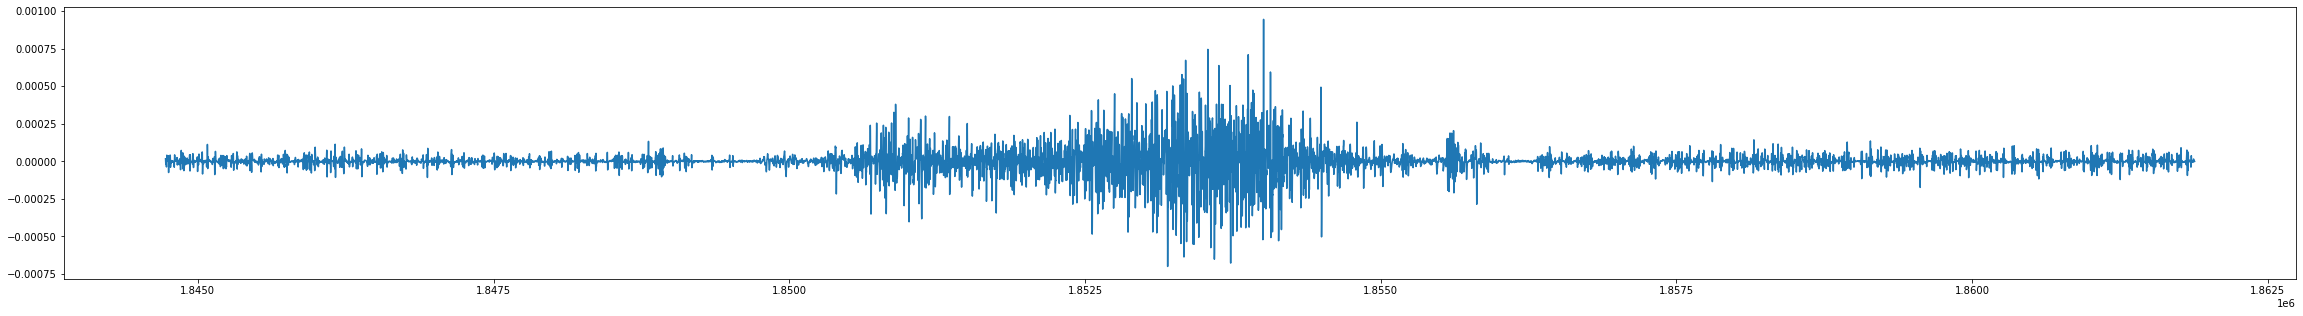

In [14]:
figure(figsize=(40,5))
plt.plot(S40_C1_Gn)
plt.show()

## EWT result with 10 boundaries (N=10)

In [15]:
import librosa
import librosa.display
import ewtpy

In [16]:
ewt,mfb,boundaries = ewtpy.EWT1D(S40_C1_Gn, N = 10)
# show the shape of ewt
ewt

array([[-1.75991052e-06, -7.06946685e-06, -5.84275214e-06, ...,
         1.60466538e-05, -4.48968279e-06,  5.32736862e-06],
       [-1.74454426e-06, -6.85130410e-06, -5.46987428e-06, ...,
         1.06246369e-05, -2.52086712e-06, -8.18540450e-06],
       [-1.71401990e-06, -6.42292282e-06, -4.74773981e-06, ...,
         1.63591793e-06,  5.53141180e-07, -1.14339371e-05],
       ...,
       [ 6.54708868e-06, -1.26788809e-06, -4.57619171e-09, ...,
        -4.73837768e-08,  1.38658169e-06,  1.29473968e-06],
       [ 6.61320751e-06, -1.34897829e-06,  1.57243686e-08, ...,
        -1.79666720e-07,  4.82826879e-06, -6.92604203e-07],
       [ 6.63532846e-06, -1.37648985e-06,  2.27329059e-08, ...,
        -2.27869622e-07,  6.17005381e-06, -2.73452264e-06]])

In [17]:
ewt.shape

(17155, 10)

In [18]:
boundaries

array([0.11042087, 0.22084173, 0.25636685, 0.31679618, 0.38107101,
       0.42428714, 0.54679387, 0.66600446, 0.68138647])

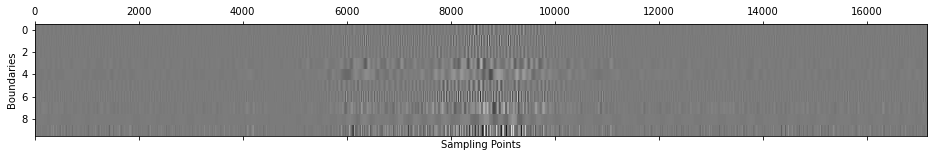

In [19]:
plt.matshow(ewt.T,aspect='auto',cmap='gray')
plt.xlabel('Sampling Points')
plt.ylabel('Boundaries')
plt.show()

Save the EWT result to csv and process in Matlab.

In [20]:
df_ewt= pd.DataFrame(ewt.T)
df_ewt.to_csv(r'C:\Ninapro\ewt.csv',header = False)

## EFD result with 10 boundaries (N=10)

In [21]:
from mat4py import loadmat
EFDfrequency = loadmat(r'C:\Ninapro\fscale.mat')

In [22]:
frq = pd.DataFrame(EFDfrequency['fscale']).transpose()

In [23]:
frq

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.0,6.725963,13.451927,20.17789,26.903854,33.629817,40.35578,47.081744,53.807707,60.533671,...,605.336707,612.06267,618.788634,625.514597,632.240561,638.966524,645.692487,652.418451,659.144414,665.870378


In [24]:
EFDts = loadmat(r'C:\Ninapro\tscale.mat')

In [25]:
ts = pd.DataFrame(EFDts['tscale']).transpose()

In [26]:
EFDnt = loadmat(r'C:\Ninapro\nt.mat')

In [27]:
nt = pd.DataFrame(EFDnt['nt'])

In [28]:
nt

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,3.057754e-11,3.595749e-12,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.468334e-11,6.365700e-11,6.282102e-11,6.195238e-11,6.153766e-11,6.087053e-11,6.087782e-11,6.041785e-11,6.081161e-11,6.052851e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
96,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
97,0.000000e+00,0.000000e+00,8.973645e-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
98,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


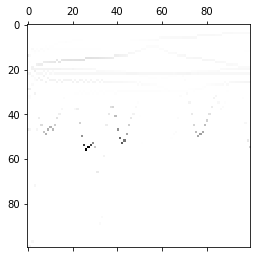

In [29]:
#basic plot
plt.matshow(-nt,aspect='auto',cmap='gray')

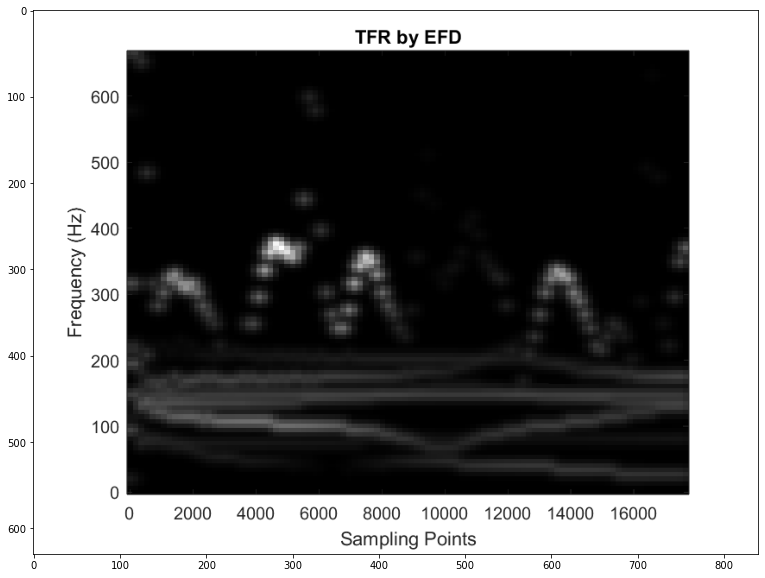

In [30]:
import matplotlib.image as mpimg
figure(figsize=(60,10))

img2 = mpimg.imread(r'C:\Ninapro\EFDPLOT.png')
imgplot = plt.imshow(img2)
plt.show()

## Prepare the images for TFR
### Cut off repetitions into sample pieces
#### 40x12x49x6

In [4]:
df1=pd.DataFrame(import_db2_acc(r'C:\Ninapro', 1))
df2=pd.DataFrame(import_db2_acc(r'C:\Ninapro', 2))
df3=pd.DataFrame(import_db2_acc(r'C:\Ninapro', 3))
df4=pd.DataFrame(import_db2_acc(r'C:\Ninapro', 4))
df5=pd.DataFrame(import_db2_acc(r'C:\Ninapro', 5))
df6=pd.DataFrame(import_db2_acc(r'C:\Ninapro', 6))
df7=pd.DataFrame(import_db2_acc(r'C:\Ninapro', 7))
df8=pd.DataFrame(import_db2_acc(r'C:\Ninapro', 8))
df9=pd.DataFrame(import_db2_acc(r'C:\Ninapro', 9))
df10=pd.DataFrame(import_db2_acc(r'C:\Ninapro', 10))
df11=pd.DataFrame(import_db2_acc(r'C:\Ninapro', 11))
df12=pd.DataFrame(import_db2_acc(r'C:\Ninapro', 12))
df13=pd.DataFrame(import_db2_acc(r'C:\Ninapro', 13))
df14=pd.DataFrame(import_db2_acc(r'C:\Ninapro', 14))
df15=pd.DataFrame(import_db2_acc(r'C:\Ninapro', 15))
df16=pd.DataFrame(import_db2_acc(r'C:\Ninapro', 16))
df17=pd.DataFrame(import_db2_acc(r'C:\Ninapro', 17))
df18=pd.DataFrame(import_db2_acc(r'C:\Ninapro', 18))
df19=pd.DataFrame(import_db2_acc(r'C:\Ninapro', 19))
df20=pd.DataFrame(import_db2_acc(r'C:\Ninapro', 20))
df21=pd.DataFrame(import_db2_acc(r'C:\Ninapro', 21))
df22=pd.DataFrame(import_db2_acc(r'C:\Ninapro', 22))
df23=pd.DataFrame(import_db2_acc(r'C:\Ninapro', 23))
df24=pd.DataFrame(import_db2_acc(r'C:\Ninapro', 24))
df25=pd.DataFrame(import_db2_acc(r'C:\Ninapro', 25))
df26=pd.DataFrame(import_db2_acc(r'C:\Ninapro', 26))
df27=pd.DataFrame(import_db2_acc(r'C:\Ninapro', 27))
df28=pd.DataFrame(import_db2_acc(r'C:\Ninapro', 28))
df29=pd.DataFrame(import_db2_acc(r'C:\Ninapro', 29))

In [5]:
df30=pd.DataFrame(import_db2_acc(r'C:\Ninapro', 30))
df31=pd.DataFrame(import_db2_acc(r'C:\Ninapro', 31))
df32=pd.DataFrame(import_db2_acc(r'C:\Ninapro', 32))
df33=pd.DataFrame(import_db2_acc(r'C:\Ninapro', 33))
df34=pd.DataFrame(import_db2_acc(r'C:\Ninapro', 34))
df35=pd.DataFrame(import_db2_acc(r'C:\Ninapro', 35))
df36=pd.DataFrame(import_db2_acc(r'C:\Ninapro', 36))
df37=pd.DataFrame(import_db2_acc(r'C:\Ninapro', 37))
df38=pd.DataFrame(import_db2_acc(r'C:\Ninapro', 38))
df39=pd.DataFrame(import_db2_acc(r'C:\Ninapro', 39))
df40=pd.DataFrame(import_db2_acc(r'C:\Ninapro', 40))

In [6]:
S1=import_db2_unrefined(r'C:\Ninapro', 1, rest_length_cap=999)['rep_regions']
S2=import_db2_unrefined(r'C:\Ninapro', 2, rest_length_cap=999)['rep_regions']
S3=import_db2_unrefined(r'C:\Ninapro', 3, rest_length_cap=999)['rep_regions']
S4=import_db2_unrefined(r'C:\Ninapro', 4, rest_length_cap=999)['rep_regions']
S5=import_db2_unrefined(r'C:\Ninapro', 5, rest_length_cap=999)['rep_regions']
S6=import_db2_unrefined(r'C:\Ninapro', 6, rest_length_cap=999)['rep_regions']
S7=import_db2_unrefined(r'C:\Ninapro', 7, rest_length_cap=999)['rep_regions']
S8=import_db2_unrefined(r'C:\Ninapro', 8, rest_length_cap=999)['rep_regions']
S9=import_db2_unrefined(r'C:\Ninapro', 9, rest_length_cap=999)['rep_regions']
S10=import_db2_unrefined(r'C:\Ninapro', 10, rest_length_cap=999)['rep_regions']
S11=import_db2_unrefined(r'C:\Ninapro', 11, rest_length_cap=999)['rep_regions']
S12=import_db2_unrefined(r'C:\Ninapro', 12, rest_length_cap=999)['rep_regions']
S13=import_db2_unrefined(r'C:\Ninapro', 13, rest_length_cap=999)['rep_regions']
S14=import_db2_unrefined(r'C:\Ninapro', 14, rest_length_cap=999)['rep_regions']
S15=import_db2_unrefined(r'C:\Ninapro', 15, rest_length_cap=999)['rep_regions']
S16=import_db2_unrefined(r'C:\Ninapro', 16, rest_length_cap=999)['rep_regions']
S17=import_db2_unrefined(r'C:\Ninapro', 17, rest_length_cap=999)['rep_regions']
S18=import_db2_unrefined(r'C:\Ninapro', 18, rest_length_cap=999)['rep_regions']
S19=import_db2_unrefined(r'C:\Ninapro', 19, rest_length_cap=999)['rep_regions']
S20=import_db2_unrefined(r'C:\Ninapro', 20, rest_length_cap=999)['rep_regions']

In [ ]:
S21=import_db2_unrefined(r'C:\Ninapro', 21, rest_length_cap=999)['rep_regions']
S22=import_db2_unrefined(r'C:\Ninapro', 22, rest_length_cap=999)['rep_regions']
S23=import_db2_unrefined(r'C:\Ninapro', 23, rest_length_cap=999)['rep_regions']
S24=import_db2_unrefined(r'C:\Ninapro', 24, rest_length_cap=999)['rep_regions']
S25=import_db2_unrefined(r'C:\Ninapro', 25, rest_length_cap=999)['rep_regions']
S26=import_db2_unrefined(r'C:\Ninapro', 26, rest_length_cap=999)['rep_regions']
S27=import_db2_unrefined(r'C:\Ninapro', 27, rest_length_cap=999)['rep_regions']
S28=import_db2_unrefined(r'C:\Ninapro', 28, rest_length_cap=999)['rep_regions']
S29=import_db2_unrefined(r'C:\Ninapro', 29, rest_length_cap=999)['rep_regions']
S30=import_db2_unrefined(r'C:\Ninapro', 30, rest_length_cap=999)['rep_regions']
S31=import_db2_unrefined(r'C:\Ninapro', 31, rest_length_cap=999)['rep_regions']
S32=import_db2_unrefined(r'C:\Ninapro', 32, rest_length_cap=999)['rep_regions']
S33=import_db2_unrefined(r'C:\Ninapro', 33, rest_length_cap=999)['rep_regions']
S34=import_db2_unrefined(r'C:\Ninapro', 34, rest_length_cap=999)['rep_regions']
S35=import_db2_unrefined(r'C:\Ninapro', 35, rest_length_cap=999)['rep_regions']
S36=import_db2_unrefined(r'C:\Ninapro', 36, rest_length_cap=999)['rep_regions']
S37=import_db2_unrefined(r'C:\Ninapro', 37, rest_length_cap=999)['rep_regions']
S38=import_db2_unrefined(r'C:\Ninapro', 38, rest_length_cap=999)['rep_regions']
S39=import_db2_unrefined(r'C:\Ninapro', 39, rest_length_cap=999)['rep_regions']
S40=import_db2_unrefined(r'C:\Ninapro', 40, rest_length_cap=999)['rep_regions']

In [35]:
pieces=[]
 
for sub in range(1,41):
    for i in range(1,13):
        for j in range(1,50):
            for k in range(1,7):
                names='S'+str(sub)+'_C'+str(i)+'_G'+str(j)+'_T'+str(k)
                pieces.append(names)

In [36]:
len(pieces)

141120

In [37]:
#import re

#r = re.compile(r"^S[1-9]?[0-9]_C[1-9]?[0-9]_G?[1-3]_T[1-6]")
#newlist = list(filter(r.match, pieces))
a=[]
dfs=[df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12,df13,df14,df15,df16,df17,df18,df19,df20,df21,df22,
     df23,df24,df25,df26,df27,df28,df29,df30,df31,df32,df33,df34,df35,df36,df37,df38,df39,df40]
cutpoints=[S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14,S15,S16,S17,S18,S19,S20,S21,S22,
           S23,S24,S25,S26,S27,S28,S29,S30,S31,S32,S33,S34,S35,S36,S37,S38,S39,S40]
for p in range(40):
    for channel in range(12):
        for point in range(0,588,2):
            a.append(dfs[p][channel][cutpoints[p][point]:cutpoints[p][point+1]])

In [22]:
fullpoint=[]
for i in range(len(pieces)):
    str = pieces[i]
    globals()[str] = a[i]
    fullpoint.append(globals()[str])

In [5]:
import os

In [30]:
for lp in range(len(pieces)):
    filename=pieces[lp]+'.csv'
    saveto=os.path.join('C:\\Ninapro\\pieces\\', filename)
    fullpoint[lp].to_csv(saveto,index=False,header=False)

In [26]:
import librosa
import librosa.display
import ewtpy
import csv

In [63]:
ewt=[]
mfb=[]
boundaries=[]
index=index_list[0:432]
for k in index:
    a,b,c = ewtpy.EWT1D(fullpoint[k], N = 10)
    ewt_S1.append(a)
    mfb_S1.append(b)
    boundaries_S1.append(c)

In [55]:
ewt_S1=ewt[0:216]
ewt_S2=ewt[216:432]

In [19]:
np.save(r'C:\Ninapro\testingss.npy', c)


### Plot examples of the images

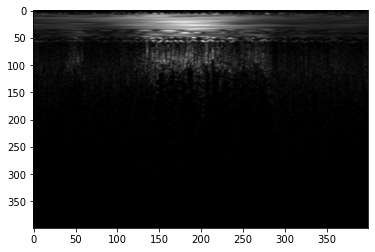

In [7]:
img_tt=pd.read_csv(r"C:\Ninapro\efd_result\3\efdS39_C7_G3_T6.csv")
#basic plot
plt.imshow(img_tt,aspect='auto',cmap='gray')

In [9]:
img_tt.shape

(399, 400)

In [21]:
for m in range(1,41):
    for p in range(1,7):
        filenames2='npS'+str(m)+'_G2'+'_T'+str(p)+'.npy'
        save_file2=os.path.join('C:\\Ninapro\\efd_result\\2\\',filenames2)

        a1=pd.read_csv(os.path.join('C:\\Ninapro\\efd_result\\2\\','efdS'+str(m)+'_C1_G2'+'_T'+str(p)+'.csv'))
        a2=pd.read_csv(os.path.join('C:\\Ninapro\\efd_result\\2\\','efdS'+str(m)+'_C2_G2'+'_T'+str(p)+'.csv'))
        a3=pd.read_csv(os.path.join('C:\\Ninapro\\efd_result\\2\\','efdS'+str(m)+'_C3_G2'+'_T'+str(p)+'.csv'))
        a4=pd.read_csv(os.path.join('C:\\Ninapro\\efd_result\\2\\','efdS'+str(m)+'_C4_G2'+'_T'+str(p)+'.csv'))
        a5=pd.read_csv(os.path.join('C:\\Ninapro\\efd_result\\2\\','efdS'+str(m)+'_C5_G2'+'_T'+str(p)+'.csv'))
        a6=pd.read_csv(os.path.join('C:\\Ninapro\\efd_result\\2\\','efdS'+str(m)+'_C6_G2'+'_T'+str(p)+'.csv'))
        a7=pd.read_csv(os.path.join('C:\\Ninapro\\efd_result\\2\\','efdS'+str(m)+'_C7_G2'+'_T'+str(p)+'.csv'))
        a8=pd.read_csv(os.path.join('C:\\Ninapro\\efd_result\\2\\','efdS'+str(m)+'_C8_G2'+'_T'+str(p)+'.csv'))
        a9=pd.read_csv(os.path.join('C:\\Ninapro\\efd_result\\2\\','efdS'+str(m)+'_C9_G2'+'_T'+str(p)+'.csv'))
        a10=pd.read_csv(os.path.join('C:\\Ninapro\\efd_result\\2\\','efdS'+str(m)+'_C10_G2'+'_T'+str(p)+'.csv'))
        a11=pd.read_csv(os.path.join('C:\\Ninapro\\efd_result\\2\\','efdS'+str(m)+'_C11_G2'+'_T'+str(p)+'.csv'))
        a12=pd.read_csv(os.path.join('C:\\Ninapro\\efd_result\\2\\','efdS'+str(m)+'_C12_G2'+'_T'+str(p)+'.csv'))


        d = np.stack ((a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12)).T
        np.save(save_file2, d)


In [22]:
for m in range(1,41):
    for p in range(1,7):
        filenames3='npS'+str(m)+'_G3'+'_T'+str(p)+'.npy'
        save_file3=os.path.join('C:\\Ninapro\\efd_result\\3\\',filenames3)

        a1=pd.read_csv(os.path.join('C:\\Ninapro\\efd_result\\3\\','efdS'+str(m)+'_C1_G3'+'_T'+str(p)+'.csv'))
        a2=pd.read_csv(os.path.join('C:\\Ninapro\\efd_result\\3\\','efdS'+str(m)+'_C2_G3'+'_T'+str(p)+'.csv'))
        a3=pd.read_csv(os.path.join('C:\\Ninapro\\efd_result\\3\\','efdS'+str(m)+'_C3_G3'+'_T'+str(p)+'.csv'))
        a4=pd.read_csv(os.path.join('C:\\Ninapro\\efd_result\\3\\','efdS'+str(m)+'_C4_G3'+'_T'+str(p)+'.csv'))
        a5=pd.read_csv(os.path.join('C:\\Ninapro\\efd_result\\3\\','efdS'+str(m)+'_C5_G3'+'_T'+str(p)+'.csv'))
        a6=pd.read_csv(os.path.join('C:\\Ninapro\\efd_result\\3\\','efdS'+str(m)+'_C6_G3'+'_T'+str(p)+'.csv'))
        a7=pd.read_csv(os.path.join('C:\\Ninapro\\efd_result\\3\\','efdS'+str(m)+'_C7_G3'+'_T'+str(p)+'.csv'))
        a8=pd.read_csv(os.path.join('C:\\Ninapro\\efd_result\\3\\','efdS'+str(m)+'_C8_G3'+'_T'+str(p)+'.csv'))
        a9=pd.read_csv(os.path.join('C:\\Ninapro\\efd_result\\3\\','efdS'+str(m)+'_C9_G3'+'_T'+str(p)+'.csv'))
        a10=pd.read_csv(os.path.join('C:\\Ninapro\\efd_result\\3\\','efdS'+str(m)+'_C10_G3'+'_T'+str(p)+'.csv'))
        a11=pd.read_csv(os.path.join('C:\\Ninapro\\efd_result\\3\\','efdS'+str(m)+'_C11_G3'+'_T'+str(p)+'.csv'))
        a12=pd.read_csv(os.path.join('C:\\Ninapro\\efd_result\\3\\','efdS'+str(m)+'_C12_G3'+'_T'+str(p)+'.csv'))


        f = np.stack ((a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12)).T
        np.save(save_file3, f)


In [20]:
for m in range(1,41):
    for p in range(1,7):
        filenames1='npS'+str(m)+'_G1'+'_T'+str(p)+'.npy'
        save_file=os.path.join('C:\\Ninapro\\efd_result\\1\\',filenames1)

        a1=pd.read_csv(os.path.join('C:\\Ninapro\\efd_result\\1\\','efdS'+str(m)+'_C1_G1'+'_T'+str(p)+'.csv'))
        a2=pd.read_csv(os.path.join('C:\\Ninapro\\efd_result\\1\\','efdS'+str(m)+'_C2_G1'+'_T'+str(p)+'.csv'))
        a3=pd.read_csv(os.path.join('C:\\Ninapro\\efd_result\\1\\','efdS'+str(m)+'_C3_G1'+'_T'+str(p)+'.csv'))
        a4=pd.read_csv(os.path.join('C:\\Ninapro\\efd_result\\1\\','efdS'+str(m)+'_C4_G1'+'_T'+str(p)+'.csv'))
        a5=pd.read_csv(os.path.join('C:\\Ninapro\\efd_result\\1\\','efdS'+str(m)+'_C5_G1'+'_T'+str(p)+'.csv'))
        a6=pd.read_csv(os.path.join('C:\\Ninapro\\efd_result\\1\\','efdS'+str(m)+'_C6_G1'+'_T'+str(p)+'.csv'))
        a7=pd.read_csv(os.path.join('C:\\Ninapro\\efd_result\\1\\','efdS'+str(m)+'_C7_G1'+'_T'+str(p)+'.csv'))
        a8=pd.read_csv(os.path.join('C:\\Ninapro\\efd_result\\1\\','efdS'+str(m)+'_C8_G1'+'_T'+str(p)+'.csv'))
        a9=pd.read_csv(os.path.join('C:\\Ninapro\\efd_result\\1\\','efdS'+str(m)+'_C9_G1'+'_T'+str(p)+'.csv'))
        a10=pd.read_csv(os.path.join('C:\\Ninapro\\efd_result\\1\\','efdS'+str(m)+'_C10_G1'+'_T'+str(p)+'.csv'))
        a11=pd.read_csv(os.path.join('C:\\Ninapro\\efd_result\\1\\','efdS'+str(m)+'_C11_G1'+'_T'+str(p)+'.csv'))
        a12=pd.read_csv(os.path.join('C:\\Ninapro\\efd_result\\1\\','efdS'+str(m)+'_C12_G1'+'_T'+str(p)+'.csv'))


        c = np.stack ((a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12)).T
        np.save(save_file, c)


In [ ]:
import numpy as np

efd_array = np.load('xxxxxxx.npy')


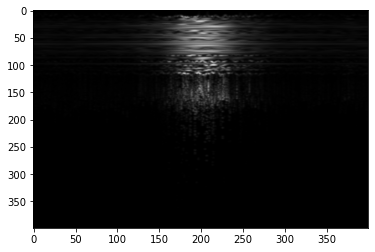

In [11]:
img_tt2=pd.read_csv(r"C:\Ninapro\efd_result\2\efdS40_C8_G2_T1.csv")
#basic plot
plt.imshow(img_tt2,aspect='auto',cmap='gray')

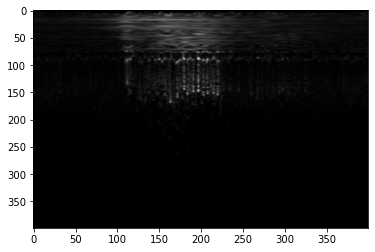

In [40]:
img_tt3=pd.read_csv(r"C:\Ninapro\efd_result\efdS6_C2_G3_T6.csv")
#basic plot
plt.imshow(img_tt3,aspect='auto',cmap='gray')

In [3]:
import os
arr = os.listdir(r'C:\Ninapro\efd_result\1')

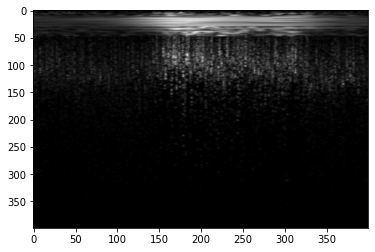

In [14]:
for example_pic in range(100):
    get_file=os.path.join('C:\\Ninapro\\efd_result\\1\\', arr[example_pic])
    img_=pd.read_csv(get_file)
    save_file=os.path.join('C:\\Ninapro\\image_examples\\1\\', arr[example_pic][:-4])
    plt.imshow(img_,aspect='auto',cmap='gray')
    plt.savefig(save_file,bbox_inches='tight', dpi=150)

## Attempt ResNet

In [133]:
from keras.models import Model
from keras.layers import Add, Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.optimizers import Adam

In [134]:
from keras.optimizers import SGD, Adam
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(lr=0.0001)
#model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\16468\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [135]:
def resBlock(input_tensor, num_channels):
    conv1 = Conv2D(num_channels,(3,3),padding='same')(input_tensor)
    relu  = Activation('relu')(conv1)
    conv2 = Conv2D(num_channels,(3,3),padding='same')(relu)
    add   = Add()([input_tensor, conv2])

    output_tensor = Activation('relu')(add)
    return output_tensor

def build_resnet_model(height,width,num_channels,num_res_blocks):
    inp       = Input(shape=(height,width,3))
    conv      = Conv2D (num_channels,(3,3),padding='same')(inp)
    block_out = Activation('relu')(conv)

    for i in np.arange(0,num_res_blocks):
        block_out = resBlock(block_out, num_channels)

    conv_m2   = Conv2D (3,(3,3),padding='same')(block_out)
    add_m2    = Add()([inp, conv_m2])
    model     = Model(inputs =inp,outputs = add_m2)

    return model

model = build_resnet_model(32,32,32,5)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 32, 32, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 32)   9248        ['activation[0][0]']             
                                                                                              

## STOP HERE
## ------Miscellaneous Attempt Code---

### Try CWT

In [30]:
# Finding CWT using mexican hat wavelet
coef, freqs = pywt.cwt(S40_C1_Gn, scales, 'mexh')  
figure(figsize=(40, 30))

plt.matshow(coef,aspect='auto',cmap='gray')
plt.xlabel('Sampling Points')
plt.ylabel('Wavelet Scales')
plt.show()

NameError: name 'scales' is not defined

In [ ]:
coef

## Looping Subjects

In [ ]:
for i in range(40):
    
len(import_db2_unrefined(r'C:\Ninapro', 40, rest_length_cap=999)['rep_regions'])
S40=import_db2_unrefined(r'C:\Ninapro', 40, rest_length_cap=999)['rep_regions']

## MNE library

In [50]:
import mne

## Separate guestures

In [26]:
def import_db2_acc(folder_path, subject):
    """Function for extracting acceleronmeter data from raw NinaiPro files for DB2.
    Args:
        folder_path (string): Path to folder containing raw mat files
        subject (int): 1-40 which subject's data to import
    Returns:
        array: Raw accceleronmeter from each electrode
    """
    cur_path = os.path.normpath(folder_path + '/S' + str(subject) + '_E1_A1.mat')
    data = sio.loadmat(cur_path)
    acc = np.squeeze(np.array(data['acc']))

    cur_path = os.path.normpath(folder_path + '/S' + str(subject) + '_E2_A1.mat')
    data = sio.loadmat(cur_path)
    acc = np.vstack((acc, np.array(data['acc'])))

    cur_path = os.path.normpath(folder_path + '/S' + str(subject) + '_E3_A1.mat')
    data = sio.loadmat(cur_path)
    acc = np.vstack((acc, np.array(data['acc'])))

    return acc

(588,)

### Short time FT

In [71]:
f, t, Zxx = signal.stft(sig, 2000)
plt.pcolormesh(t, f, np.abs(Zxx))
#plt.title('STFT Magnitude')
#plt.ylabel('Frequency [Hz]')
##plt.xlabel('Time [sec]')
plt.show()

In [73]:
t1 = np.linspace(0, 0.5, 1000)

# Finding signal by adding three different signals
signal = sig
scales = np.arange(1, 1000)  # No. of scales

### WT tools

In [ ]:
def plot_wavelet(time, signal, scales, 
                 waveletname = 'cmor', 
                 cmap = plt.cm.seismic, 
                 title = 'Wavelet Transform of signal', 
                 ylabel = 'Frequncy', 
                 xlabel = 'Time'):
    
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    contourlevels = np.log2(levels)
    
    fig, ax = plt.subplots(figsize=(15, 10))
    im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)
    
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    
    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    ax.set_yticks(np.log2(yticks))
    ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], -1)
    
    cbar_ax = fig.add_axes([0.95, 0.5, 0.03, 0.25])
    fig.colorbar(im, cax=cbar_ax, orientation="vertical")
    plt.show()
 

def plot_signal_plus_average(time, signal, average_over = 5):
    fig, ax = plt.subplots(figsize=(15, 3))
    time_ave, signal_ave = get_ave_values(time, signal, average_over)
    ax.plot(time, signal, label='signal')
    ax.plot(time_ave, signal_ave, label = 'time average (n={})'.format(5))
    ax.set_xlim([time[0], time[-1]])
    ax.set_ylabel('Signal Amplitude', fontsize=18)
    ax.set_title('Signal + Time Average', fontsize=18)
    ax.set_xlabel('Time', fontsize=18)
    ax.legend()
    plt.show()
    
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values
 
def plot_fft_plus_power(time, signal):
    dt = time[1] - time[0]
    N = len(signal)
    fs = 1/dt
    
    fig, ax = plt.subplots(figsize=(15, 3))
    variance = np.std(signal)**2
    f_values, fft_values = get_fft_values(signal, dt, N, fs)
    fft_power = variance * abs(fft_values) ** 2     # FFT power spectrum
    ax.plot(f_values, fft_values, 'r-', label='Fourier Transform')
    ax.plot(f_values, fft_power, 'k--', linewidth=1, label='FFT Power Spectrum')
    ax.set_xlabel('Frequency [Hz / year]', fontsize=18)
    ax.set_ylabel('Amplitude', fontsize=18)
    ax.legend()
    plt.show()


In [ ]:
scales = np.arange(1, 128)
plot_signal_plus_average(time, signal)
plot_fft_plus_power(time, signal)
plot_wavelet(time, signal, scales)

In [ ]:
X = data['two'].values*10000
split = round(len(X) / 6)
X1, X2 = X[0:split], X[split:2*split]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=0.000021, mean2=-0.000099
variance1=0.053503, variance2=0.136650


In [ ]:
from statsmodels.tsa.stattools import adfuller


In [ ]:
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

In [ ]:
data_m=data.copy()
for j in ['one','two','three','four','five','six','seven', 'eight', 'nine','ten','eleven','twelve']:
    sig=np.array(data[j])
    sig_ftt=fftpack.fft(sig)
    newcol=j+'fft'
    data_m[newcol]=sig_ftt

https://github.com/SebastianRestrepoA/EMG-pattern-recognition/blob/master/feature_extraction_scheme.py

In [ ]:

def myopulse(signal, th):
    umbral = signal >= th
    return np.sum(umbral) / len(signal)

def wilson_amplitude(signal, th):
    x = abs(np.diff(signal))
    umbral = x >= th
    return np.sum(umbral)

def shannon(x):
    N = len(x)
    nb = 19
    hist, bin_edges = np.histogram(x, bins=nb)
    counts = hist / N
    nz = np.nonzero(counts)

    return np.sum(counts[nz] * np.log(counts[nz]) / np.log(2))


def zcruce(X, th):
    th = 0
    cruce = 0
    for cont in range(len(X) - 1):
        can = X[cont] * X[cont + 1]
        can2 = abs(X[cont] - X[cont + 1])
        if can < 0 and can2 > th:
            cruce = cruce + 1
    return cruce

def time_features_estimation(signal, window_size, step):
    """
    Compute time features from signal using sliding window method.
    :param step: sliding window step size.
    :return: time_features_matrix: narray matrix with the time features stacked by columns.
    """

    variance = []
    rms = []
    iemg = []
    mav = []
    log_detector = []
    wl = []
    aac = []
    dasdv = []
    zc = []
    wamp = []
    myop = []

    th = np.mean(signal) + 3 * np.std(signal)

    for i in range(window_size, signal.size, step):
        x = signal[i - window_size:i]

        variance.append(np.var(x))
        rms.append(np.sqrt(np.mean(x ** 2)))
        iemg.append(np.sum(abs(x)))  # Integral
        mav.append(np.sum(np.absolute(x)) / window_size)  # Mean Absolute Value
        log_detector.append(np.exp(np.sum(np.log10(np.absolute(x))) / window_size))
        wl.append(np.sum(abs(np.diff(x))))  # Wavelength
        aac.append(np.sum(abs(np.diff(x))) / window_size)  # Average Amplitude Change
        dasdv.append(
            math.sqrt((1 / (window_size - 1)) * np.sum((np.diff(x)) ** 2)))  # Difference absolute standard deviation value
        zc.append(zcruce(x, th))  # Zero-Crossing
        wamp.append(wilson_amplitude(x, th))  # Willison amplitude
        myop.append(myopulse(x, th))  # Myopulse percentage rate

    time_features_matrix = np.column_stack((variance, rms, iemg, mav, log_detector, wl, aac, dasdv, zc, wamp, myop))
    return time_features_matrix

In [ ]:
sig=np.array(data_m['one'])

In [ ]:
TF=time_features_estimation(sig, 250, 125)

In [ ]:
TF_DF=pd.DataFrame(TF)
TF_DF

,0,1,2,3,4,5,6,7,8,9,10
0,5.562874e-11,0.000007,0.001286,0.000005,0.004034,0.000659,0.000003,0.000004,35.0,0.0,0.000
1,2.256944e-10,0.000015,0.001785,0.000007,0.004077,0.000947,0.000004,0.000009,38.0,0.0,0.000
2,2.119089e-10,0.000015,0.001558,0.000006,0.003699,0.000875,0.000003,0.000008,44.0,0.0,0.000
3,2.954106e-11,0.000005,0.000867,0.000003,0.003364,0.000485,0.000002,0.000003,43.0,0.0,0.000
4,4.920931e-11,0.000007,0.001071,0.000004,0.003521,0.000559,0.000002,0.000004,41.0,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...
14460,3.578461e-10,0.000019,0.002871,0.000011,0.005389,0.001501,0.000006,0.000011,41.0,0.0,0.000
14461,7.600789e-10,0.000028,0.004080,0.000016,0.006119,0.002141,0.000009,0.000017,41.0,1.0,0.008
14462,6.736439e-10,0.000026,0.003623,0.000014,0.005734,0.001892,0.000008,0.000015,43.0,1.0,0.008
14463,7.247999e-10,0.000027,0.003565,0.000014,0.005363,0.001876,0.000008,0.000016,41.0,0.0,0.008


In [ ]:
def next_power_of_2(x):
    return 1 if x == 0 else 2 ** (x - 1).bit_length()
def spectrum(signal, fs):
    m = len(signal)
    n = next_power_of_2(m)
    y = np.fft.fft(signal, n)
    yh = y[0:int(n / 2 - 1)]
    fh = (fs / n) * np.arange(0, n / 2 - 1, 1)
    power = np.real(yh * np.conj(yh) / n)

    return fh, power

def median_freq(frequency, power):
    power_total = np.sum(power) / 2
    temp = 0
    tol = 0.01
    errel = 1
    i = 0

    while abs(errel) > tol:
        temp += power[i]
        errel = (power_total - temp) / power_total
        i += 1
        if errel < 0:
            errel = 0
            i -= 1

    return frequency[i]

def frequency_ratio(frequency, power):
    power_low = power[(frequency >= 30) & (frequency <= 250)]
    power_high = power[(frequency > 250) & (frequency <= 500)]
    ULC = np.sum(power_low)
    UHC = np.sum(power_high)

    return ULC / UHC
def mean_freq(frequency, power):
    num = 0
    den = 0
    for i in range(int(len(power) / 2)):
        num += frequency[i] * power[i]
        den += power[i]

    return num / den


def frequency_features_estimation(signal, fs, frame, step):
    """
    Compute frequency features from signal using sliding window method.
    :param signal: numpy array signal.
    :param fs: sampling frequency of the signal.
    :param frame: sliding window size
    :param step: sliding window step size
    :return: frequency_features_matrix: narray matrix with the frequency features stacked by columns.
    """

    fr = []
    mnp = []
    tot = []
    mnf = []
    mdf = []
    pkf = []

    for i in range(frame, signal.size, step):
        x = signal[i - frame:i]
        frequency, power = spectrum(x, fs)

        fr.append(frequency_ratio(frequency, power))  # Frequency ratio
        mnp.append(np.sum(power) / len(power))  # Mean power
        tot.append(np.sum(power))  # Total power
        mnf.append(mean_freq(frequency, power))  # Mean frequency
        mdf.append(median_freq(frequency, power))  # Median frequency
        pkf.append(frequency[power.argmax()])  # Peak frequency

    frequency_features_matrix = np.column_stack((fr, mnp, tot, mnf, mdf, pkf))

    return frequency_features_matrix


In [ ]:
FF=frequency_features_estimation(sig, 2000, 250, 125)
FF_DF=pd.DataFrame(FF)
FF_DF

,0,1,2,3,4,5
0,8.776482,5.478137e-11,6.957234e-09,148.081494,132.8125,109.3750
1,7.991139,2.227038e-10,2.828339e-08,165.277520,156.2500,187.5000
2,7.184920,2.090116e-10,2.654447e-08,169.234817,164.0625,179.6875
3,5.322381,2.927442e-11,3.717851e-09,160.835822,156.2500,156.2500
4,7.572994,4.841705e-11,6.148966e-09,158.210166,148.4375,101.5625
...,...,...,...,...,...,...
14460,5.378575,3.522923e-10,4.474113e-08,165.036224,164.0625,171.8750
14461,4.198952,7.485591e-10,9.506700e-08,174.249182,156.2500,125.0000
14462,4.733784,6.631208e-10,8.421634e-08,172.557304,156.2500,125.0000
14463,5.825032,7.137132e-10,9.064158e-08,168.874750,164.0625,171.8750


In [ ]:
def wavelet_energy(x, mother, nivel):
    coeffs = pywt.wavedecn(x, wavelet=mother, level=nivel)
    arr, _ = pywt.coeffs_to_array(coeffs)
    Et = np.sum(arr ** 2)
    cA = coeffs[0]
    Ea = 100 * np.sum(cA ** 2) / Et
    Ed = []

    for k in range(1, len(coeffs)):
        cD = list(coeffs[k].values())
        cD = np.asarray(cD)
        Ed.append(100 * np.sum(cD ** 2) / Et)

    return Ea, Ed

def time_frequency_features_estimation(signal, frame, step):
    """
    Compute time-frequency features from signal using sliding window method.
    :param signal: numpy array signal.
    :param frame: sliding window size
    :param step: sliding window step size
    :return: h_wavelet: list
    """
    h_wavelet = []

    for i in range(frame, signal.size, step):
        x = signal[i - frame:i]

        E_a, E = wavelet_energy(x, 'db2', 4)
        E.insert(0, E_a)
        E = np.asarray(E) / 100

        h_wavelet.append(-np.sum(E * np.log2(E)))

    return h_wavelet


https://codeocean.com/capsule/9381036/tree/v1

In [ ]:

def plot_features(signal, channel_name, fs, feature_matrix, step):
    """
    xxxs
    Argument:
    signal -- python numpy array representing recording of a signal.
    channel_name -- string variable with the EMG channel name in analysis.
    fs -- int variable with the sampling frequency used to acquire the signal.
    feature_matrix -- python Dataframe ...
    step -- int variable with the step size used in the sliding window method.
    """

    ts = np.arange(0, len(signal) / fs, 1 / fs)
    # for idx, f in enumerate(tfeatures.T):
    for key in feature_matrix.T:
        tf = step * (np.arange(0, len(feature_matrix.T[key]) / fs, 1 / fs))
        fig = plt.figure()

        ax = fig.add_subplot(111, label="1")
        ax2 = fig.add_subplot(111, label="2", frame_on=False)
        ax.plot(ts, signal, color="C0")
        ax.autoscale(tight=True)
        plt.title(channel_name + ": " + key)
        ax.set_xlabel("Time")
        ax.set_ylabel("mV")

        ax2.plot(tf, feature_matrix.T[key], color="red")
        ax2.yaxis.tick_right()
        ax2.autoscale(tight=True)
        ax2.set_xticks([])
        ax2.set_yticks([])
        mng = plt.get_current_fig_manager()
        mng.window.state('zoomed')
        plt.show()


In [ ]:
amp=np.abs(sig_ftt)

In [ ]:
power=amp**2


1808331

In [ ]:
def features_estimation(signal, channel_name, fs, frame, step, plot=False):
    """
    Compute time, frequency and time-frequency features from signal.
    :param signal: numpy array signal.
    :param channel_name: string variable with the EMG channel name in analysis.
    :param fs: int variable with the sampling frequency used to acquire the signal
    :param frame: sliding window size
    :param step: sliding window step size
    :param plot: bolean variable to plot estimated features.
    :return: total_feature_matrix -- python Dataframe with .
    :return: features_names -- python list with
    """

    features_names = ['VAR', 'RMS', 'IEMG', 'MAV', 'LOG', 'WL', 'ACC', 'DASDV', 'ZC', 'WAMP', 'MYOP', "FR", "MNP", "TP",
                      "MNF", "MDF", "PKF", "WENT"]

    time_matrix = time_features_estimation(signal, frame, step)
    frequency_matrix = frequency_features_estimation(signal, fs, frame, step)
    time_frequency_matrix = time_frequency_features_estimation(signal, frame, step)
    total_feature_matrix = pd.DataFrame(np.column_stack((time_matrix, frequency_matrix, time_frequency_matrix)).T,
                                        index=features_names)

    print('EMG features were from channel {} extracted successfully'.format(channel_name))

    if plot:
        plot_features(signal, channel_name, fs, total_feature_matrix, step)

    return total_feature_matrix, features_names
